# DESeq2 Analysis of 2015 Data (Custom PCA Analysis)

In this notebook, we will reproduce the dendrograms from the 2015 data shown in the welcome slides

## Load packages

Load requisite R packages. 

In [1]:
library(DESeq2)
library(tools)
library(tidyverse)
library(RColorBrewer)
options(width=100)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are maske

## Prepare for Data Import

First set the directory under which the HTSeq count files are stored

In [2]:
datadir<-"~/work/HTS_SummerCourse_2017/Materials/Statistics/08032017/Data/2015"

Next, put the filenames into a data frame

In [3]:
phdata<-data.frame(fname=list.files(path=datadir,pattern="*.csv"),stringsAsFactors=FALSE)

It is always a good idea to check the dimension of the file you have read in

In [4]:
dim(phdata)

[1] 30  1

Extract the label from the filename. 

In [5]:
phdata <- phdata %>% transmute(sample=substr(fname,1,4),fname)

Add some design info to the data frame. We will add the treatment factor (the first character of the sample string: 7 or 8), the replicate id (the second character in the 

Note that tools::md5sum will add the MD5 signature for each of the HTSeq count files. You should keep track of these for the purpose of conducting reproducible analysis

In [6]:
phdata <- phdata %>% 
                mutate(trt=as.factor(substr(sample,1,1)),
                       repl=substr(sample,2,2),
                       team=substr(sample,4,4),
                       md5=tools::md5sum(file.path(datadir,fname)))
head(phdata)

sample    fname trt repl team  md5
1   7A_E 7A_E.csv   7    A    E <NA>
2   7A_G 7A_G.csv   7    A    G <NA>
3   7A_K 7A_K.csv   7    A    K <NA>
4   7A_N 7A_N.csv   7    A    N <NA>
5   7A_P 7A_P.csv   7    A    P <NA>
6   7B_E 7B_E.csv   7    B    E <NA>

Now, we import the counts. Note that the first argument is the sample table while the second is the directory storing the count files. The last argument specifies the design. More on this later.

In [7]:
dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata,directory=datadir,design=~ trt)

## Estimate library specific size factors and gene specific dispersion paramaters

Estimate Size factors

In [8]:
dds<-estimateSizeFactors(dds)

Estimate dispersion parameters

In [9]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Inspect object

In [10]:
dds

class: DESeqDataSet 
dim: 4444 30 
metadata(1): version
assays(2): counts mu
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(30): 7A_E 7A_G ... 8C_N 8C_P
colData names(5): trt repl team md5 sizeFactor

### Custom PCA

For this tutorial, we will use the expression data based on rlog transformation.

In [11]:
rlogexp<-assay(rlog(dds))

Standardize the transpose expression matrix (the standard R functions expect the samples to be across the rows)

In [12]:
rlogexpstd0<-scale(t(rlogexp))
dim(rlogexpstd0)

[1]   30 4444

Get rid of genes for which the standard deviation is NA

In [13]:
rlogexpstd<-rlogexpstd0[,!is.na(apply(rlogexpstd0,2,sd))]
dim(rlogexpstd)

[1]   30 4386

Do PC Analysis

In [14]:
myPCAobj<-prcomp(rlogexpstd,scale=FALSE)

Extract PCs (PCAobj$x) and add the rownames as a column

In [15]:
myPCA <- myPCAobj$x %>% as.data.frame %>%  rownames_to_column(var="sample")

Add sample information

In [16]:
myPCA <- myPCA %>% full_join(y=phdata,by="sample")
head(myPCA)

sample        PC1        PC2        PC3        PC4        PC5        PC6        PC7         PC8
1   7A_E -27.677597  27.060547 -16.126723   4.769109 -15.376741   2.100754  -6.762977   1.3990531
2   7A_G -46.363944 -26.821491  11.788346   6.376033  -5.789678  13.247184  14.495442 -30.5481912
3   7A_K  -5.441841  38.384253  -7.073312 -16.643327   9.312621  20.934692  -7.492317   0.6381358
4   7A_N  -3.829598  20.699172  33.893141  -4.699914  16.244292  -5.041994  10.751745   3.7943935
5   7A_P -43.084677   4.436228 -20.472341  15.518356   2.285400 -13.658420   9.345399   1.9637095
6   7B_E -25.367870  37.010684 -47.488772 -13.059942 -18.789263  17.844317 -18.091109 -11.7980541
         PC9 ⋯       PC26        PC27        PC28       PC29          PC30    fname trt repl team
1 -11.962311 ⋯   7.337445  -7.8747222 -19.4302768  3.0204936  4.695289e-14 7A_E.csv   7    A    E
2  -2.348785 ⋯   7.397445   6.6297293  -3.5001922 -5.3536496  6.583015e-14 7A_G.csv   7    A    G
3   6.268736 ⋯  12.842443  -2.7260808  -0.6559358 -0.7300715  1.742768e-14 7A_K.csv   7    A    K
4  -3.030794 ⋯  -6.851606   0.9804229  -2.4484532 -2.4311500 -5.848620e-15 7A_N.csv   7    A    N
5   7.955438 ⋯ -12.030825 -21.8697065  -0.5130635  1.2415329  3.625941e-14 7A_P.csv   7    A    P
6   1.487897 ⋯ -10.251608  -0.0150653   0.5923397  0.7081991  1.416076e-14 7B_E.csv   7    B    E
   md5
1 <NA>
2 <NA>
3 <NA>
4 <NA>
5 <NA>
6 <NA>

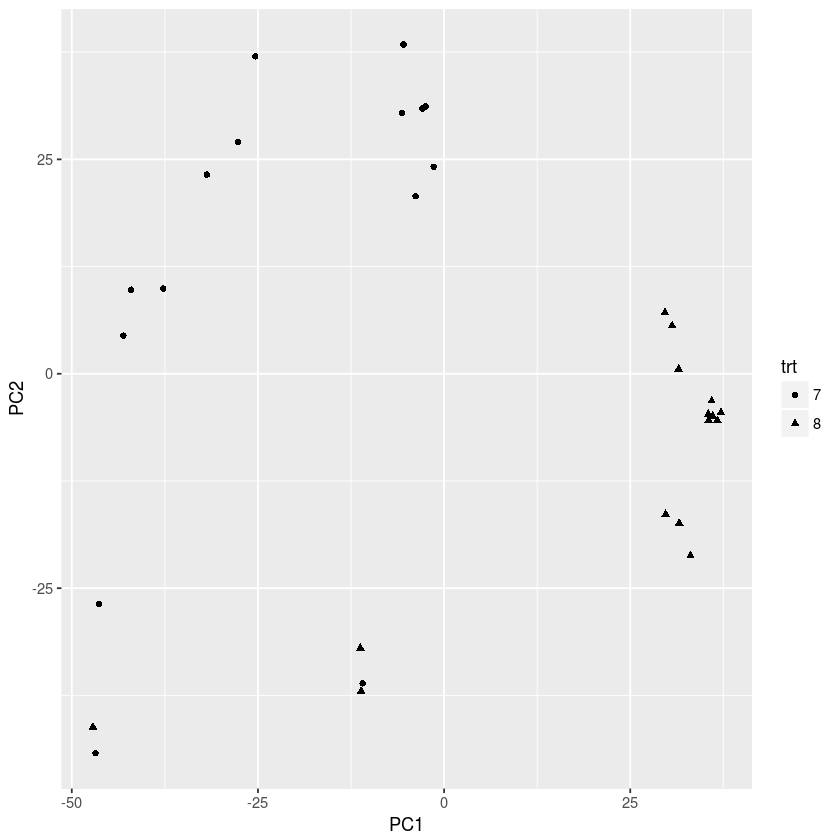

In [20]:
myPCA %>% ggplot(aes(y=PC2,x=PC1,shape=trt)) + geom_point()

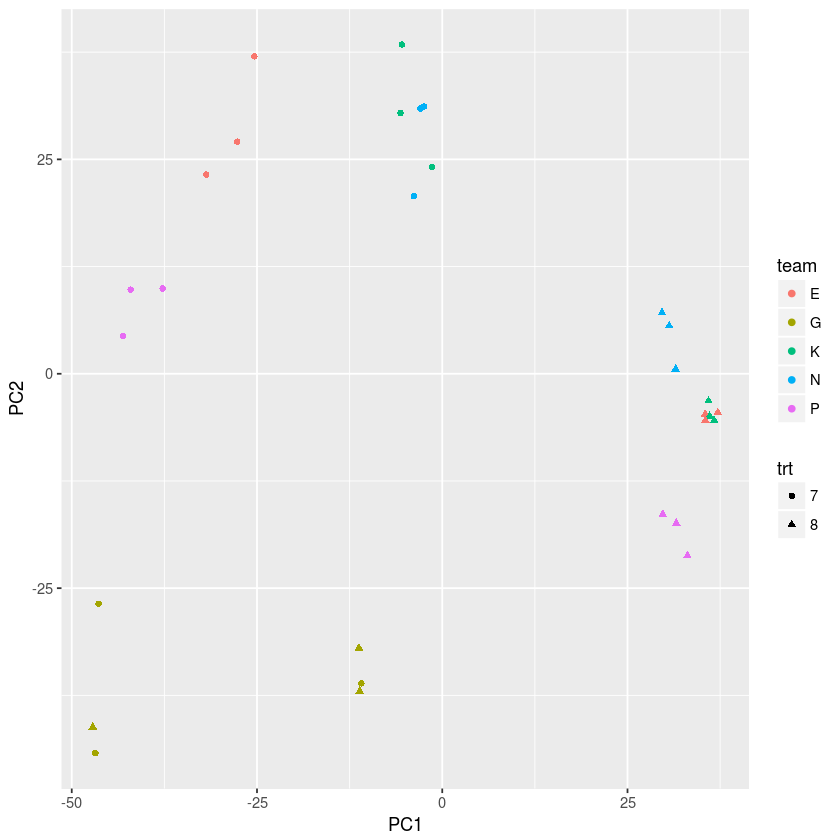

In [19]:
myPCA %>% ggplot(aes(y=PC2,x=PC1,col=team,shape=trt)) + geom_point()

In [18]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils     datasets  methods  
[10] base     

other attached packages:
 [1] RColorBrewer_1.1-2         dplyr_0.5.0                purrr_0.2.2               
 [4] readr_1.0.0                tidyr_0.6.0                tibble_1.2                
 [7] ggplot2_2.2.1              tidyverse_1.0.0            DESeq2_1.14.1             
[10] SummarizedExperiment_1.4.0 Biobase_2.34.0             GenomicRanges_1.26.4      
[13] GenomeInfoDb_1.10.3       